In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
from colour import Color
import seaborn as sn
import pandas as pd
from matplotlib.patches import Rectangle
 
import pingouin as pg
from scipy import stats
import random
import math
import statsmodels.api as sm 
from statsmodels.formula.api import ols

def outputIconForStats(pval):
    if pval <= 0.05:
        icon = '*'
    else:
        icon = ' '
    return icon

def ConvertDictToDataFrame(datadict):
    #data = {'col_1': [3, 2, 1, 0], 'col_2': ['a', 'b', 'c', 'd']}    
    X = []
    Y = []
    for key in datadict.keys():
        for ele in datadict[key]:
            X.append(ele)
            Y.append(key)
        
    data = {'X': X, 'group': Y}
    df = pd.DataFrame.from_dict(data)
    return df

def ComputeStats_group1(d_cond):
    #compare against chance
    r_data = np.random.choice([0, 1], size=len(d_cond), p=[.5, .5])
    result = pg.ttest(d_cond, r_data, correction=True) 
    pval = result.at['T-test',"p-val"]
    Tval = result.at['T-test',"T"]
    dof = math.floor(result.at['T-test',"dof"])
    icon = outputIconForStats(pval)
    return icon, pval, Tval, dof

def ComputeStats_group2(data_d1, data_d2):
    result = pg.ttest(data_d1, data_d2, correction=True) 

    # reporting format in Turing project (p < 10−15, two-tailed t-test, t = 8.5, df = 478)
    pval = result.at['T-test',"p-val"]
    Tval = result.at['T-test',"T"]
    dof = math.floor(result.at['T-test',"dof"])
    icon = outputIconForStats(pval)
    return icon, pval, Tval, dof
    
def ComputeStats_group3(data_dict):
    df = ConvertDictToDataFrame(data_dict)
    #print(df)
    mod = ols('X ~ group', data=df).fit()
    aov_table = sm.stats.anova_lm(mod, typ=2)
    
    #A one-way ANOVA revealed that there [was or was not] a statistically significant difference in [dependent variable] 
    #between at least two groups (F(between groups df, within groups df) = [F-value], p = [p-value]).
    BetweenGP_df = aov_table.df.group
    WithinGP_df = aov_table.df.Residual
    Fval = aov_table.F.group
    pval = aov_table['PR(>F)'].group
    icon = outputIconForStats(pval)
    return icon, BetweenGP_df, WithinGP_df, Fval, pval

def displayStats_group12(pval, Tval, dof):    
    if pval < 0.05:
        print('There is difference between data1 and data2.')
        if pval > 0.01 and pval < 0.05:
            print("(p < 0.05, two-tailed t-test, t = " + str("{0:.2f}".format(Tval)) + ", df = " + str(dof) + ")")
        elif pval > 0.001 and pval <= 0.01:
            print("(p < 0.01, two-tailed t-test, t = " + str("{0:.2f}".format(Tval)) + ", df = " + str(dof) + ")")
        elif pval > 0.0001 and pval <= 0.001:
            print("(p < 0.001, two-tailed t-test, t = " + str("{0:.2f}".format(Tval)) + ", df = " + str(dof) + ")")
        else:
            print("(p < 0.0001, two-tailed t-test, t = " + str("{0:.2f}".format(Tval)) + ", df = " + str(dof) + ")")
    else:
        print('There is NO difference between data1 and data2.')
        print("(p > 0.05, two-tailed t-test, t = " + str("{0:.2f}".format(Tval)) + ", df = " + str(dof) + ")")

        
def displayStats_group3(BetweenGP_df, WithinGP_df, Fval, pval):    
    print("F(" + str(BetweenGP_df) + ", " + str(WithinGP_df) + ") = " + str(Fval) +", p-val=" + str(pval))

    

def boostrap(data1, data2):
    import random
    import math
    store = []
    sample_mean = []
    if len(data1) < len(data2):
        SampleTimes = math.ceil(len(data1)/2)
        BootstrapTimes = len(data1)
    else:
        SampleTimes = math.ceil(len(data2)/2)
        BootstrapTimes = len(data2)
        
    print("bootstraptime",BootstrapTimes,"sampletime",SampleTimes)
    for i in range(BootstrapTimes):
        y1 = random.sample(data1, SampleTimes)
        #print(y1)
        y2 = random.sample(data2, SampleTimes)
        #print(y2)
        y_comb = y1+y2
        #print(y_comb)
        sample_mean.append(np.mean(np.array(y_comb), axis=0))
    
    stdval = np.std(np.array(sample_mean), axis=0)
    return stdval


def ConcatData(data1, data2):
    import random
    import math
    
    #print(data1)
    #print(data2)
    if len(data1) < len(data2):        
        BootstrapTimes = len(data1)
    else:        
        BootstrapTimes = len(data2)
    
    #print(BootstrapTimes)
    y1 = random.sample(data1, BootstrapTimes)
    #print(y1)
    y2 = random.sample(data2, BootstrapTimes)
    #print(y2)
    y_comb = y1+y2
    y_comb = np.array(y_comb)        
    return y_comb

def ComputeBarStdConfMat(contents):
    modelist = ['GBVS', 'IVSN', 'DeepGazeIII']
    print(modelist)
    
    #initialize matrix of absolute counts   
    result = {'human':0, 'countH':0, 'machine':0, 'countM': 0, 'result_H':[], 'result_M':[]}
    for modelname in modelist:
        result[modelname] = 0
        result['count_'+modelname] = 0
        result['result_'+modelname]=[]
    #print(result)

    # Iterating over keys
    for trialid in contents:
        trialinfor = contents[trialid]['trialData']

        if trialinfor['groundtruth'] == 'human':
            result['countH'] = result['countH'] + 1
            if trialinfor['response_speaker'] == trialinfor['groundtruth']:
                result['human'] = result['human'] + 1
                result['result_H'].append(1)
            else:
                result['result_H'].append(0)
                
        else:
            result['countM'] = result['countM'] + 1
            if trialinfor['response_speaker'] == trialinfor['groundtruth']:
                result['machine'] = result['machine'] + 1
                result['result_M'].append(1)
            else:
                result['result_M'].append(0)
                
            modelname = trialinfor['machine_groundtruth']
            result['count_'+modelname] = result['count_'+modelname] + 1
            if trialinfor['response_speaker'] == trialinfor['groundtruth']:
                result[modelname] = result[modelname] + 1
                result['result_' + modelname].append(1)
            else:
                result['result_' + modelname].append(0)
                
    #print(result)

    #compute confusion matrix
    result_conf_mat = np.zeros((2+len(modelist),2),'float32')
    result_conf_mat[0][0] = result['human']/result['countH']
    result_conf_mat[0][1] = (result['countH'] - result['human'])/result['countH']  
    result_conf_mat[1][0] = (result['countM'] - result['machine'])/result['countM']
    result_conf_mat[1][1] = result['machine']/result['countM']

    for i, modelname in enumerate(modelist):
        result_conf_mat[i+2][0] = (result['count_'+modelname] - result[modelname])/result['count_'+modelname]
        result_conf_mat[i+2][1] = result[modelname]/result['count_'+modelname]

    result_conf_mat = np.around(result_conf_mat, decimals=2)
    
    stdmodelist = ['M', 'GBVS', 'IVSN', 'DeepGazeIII']
    modelist_stats = ['Machine', 'GBVS', 'IVSN', 'DeepGazeIII']
    top1 = []
    top1_std = []
    resultFlist = {}
    data1tot = result['result_H']
    for i in range(1+len(modelist)):
        #print(i)
        top1.append((result_conf_mat[0][0]+result_conf_mat[i+1][1])/2)
        # compute bootstrap accuracy
        # compute and save std for top1 accuracy
        top_std_AI = boostrap(result['result_H'], result['result_' + stdmodelist[i]])
        top1_std.append(top_std_AI)
        data2tot = result['result_' + stdmodelist[i]]
        #resultFlist[modelist_stats[i]] = np.concatenate((data1tot,data2tot))
        resultFlist[modelist_stats[i]] = ConcatData(data1tot,data2tot)
        
    #print(top1)
    
    return top1, top1_std, result_conf_mat, resultFlist


### plots for grouping demographic information
def plot_res_demographics(condition_chosen_list, TextFilePath, plotname,facebarcolor, condition_results):
    
    compiledAllConds = {}
    
    modelist = ['Machine', 'GBVS', 'IVSN', 'DeepGazeIII']
    Pdata = {} #data stored for computing statistics 
    #initialize PData
    for i in range(0,len(modelist)):
        Pdata[modelist[i]] = {}
        
    for condition_chosen in condition_chosen_list:
        
        top1, top1std, result_conf_mat, resultFlist = ComputeBarStdConfMat(condition_results[condition_chosen])
        
        for i in range(0,len(modelist)):
            Pdata[modelist[i]][condition_chosen] = resultFlist[modelist[i]]
#         #compute barplot and errorbar of barplot
#         top1 = []
#         top1std = []

#         #compute confusion matrix
#         result_conf_mat = 

        compiledAllConds[condition_chosen] = top1
        compiledAllConds[condition_chosen +'_std'] = top1std
    
    ### we have the compiled resutls now; lets calculate stats
    chancePval = []
    groupPval = []
    for i in range(0,len(modelist)):
        for condition_chosen in condition_chosen_list:        
            #compute against chance 50%
            d_cond = Pdata[modelist[i]][condition_chosen]
            icon, pval, Tval, dof = ComputeStats_group1(d_cond)
            chancePval.append(icon)
        if len(Pdata[modelist[i]].keys()) == 2:
            data_d1 = Pdata[modelist[i]][condition_chosen_list[0]]
            data_d2 = Pdata[modelist[i]][condition_chosen_list[1]]
            icon, pval, Tval, dof =  ComputeStats_group2(data_d1, data_d2)
            groupPval.append(icon)
        elif len(Pdata[modelist[i]].keys()) >= 3: 
            icon, BetweenGP_df, WithinGP_df, Fval, pval = ComputeStats_group3(Pdata[modelist[i]])
            groupPval.append(icon)
        else:
            print("Oops!  This should NOT happen...")
    
    #data
    #x-axis
    years = list(range(1, len(modelist)))
    strtask = modelist
    #print(years)
    #print(strtask)

    # Figure Size
    fig, ax = plt.subplots(layout='constrained')
    x = np.arange(len(strtask))  # the label locations
    point_x = [] #for plotting stats * or n.s.
    
    width = 0.2  # the width of the bars
    if len(condition_chosen_list) == 2:
        multiplier = -0.5 #len(condition_chosen_list)
    else:
        multiplier = -1 #len(condition_chosen_list)
    #ngroups = len(condition_chosen_list)

    ax.add_patch(Rectangle((-0.5, 0.45), len(modelist), 0.1,facecolor='yellow'))
    #bar chart properties
    #ax.bar(strtask, top1, color ='black', width = 0.3)    

    for ind, condition_chosen in enumerate(condition_chosen_list):
    #for condition_chosen in condition_chosen_list:
    #for attribute, measurement in compiledAllConds.items():
        measurement = compiledAllConds[condition_chosen]
        measurement_std = compiledAllConds[condition_chosen + '_std']
        attribute = condition_chosen
        
        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, yerr= measurement_std, width = width,alpha=0.5,
                       label=attribute, edgecolor='black', color=facebarcolor[ind], ecolor='black')#,
                       #align='center', alpha=0.5, ecolor='black', capsize=10,color ='black')
        #ax.bar_label(rects, padding=3)
        point_x.extend( (x+offset).tolist() )
        multiplier += 1
    
#     ax.bar(strtask, top1, yerr=top1std,
#        align='center', alpha=0.5, ecolor='black', capsize=10,
#        color ='black', width = 0.3)

    ########## ready for plotting stats
    #print(point_x)
    ###### getting statistics
    #chancePval, groupPval = getStats(condition_chosen_list, TextFilePath)
    point_x.sort(reverse=False)
    #print(point_x)
    for i, p in enumerate(point_x):        
        ax.text(p, .7, chancePval[i], fontsize=8, transform=ax.get_xaxis_transform())

    ax.set_xticks(x, strtask)
    ax.legend(loc='upper left', ncols=len(condition_chosen_list))

    ###### plot stats for each group of bars
    totalPx = len(point_x)
#     print(totalPx)
#     print(point_x)
    count = 0
    for s1 in range(0,totalPx, len(condition_chosen_list)):
        center_x = 0
        for s2 in range(0,len(condition_chosen_list)):
            center_x = center_x + point_x[s1+s2]
        center_x = center_x/len(condition_chosen_list)
        starting_x = point_x[s1]
        ending_x = point_x[s1+len(condition_chosen_list)-1]
        plt.plot(   np.array([starting_x, ending_x]),
                           np.arange(2)*0+0.82, 'k', label='chance (50%)')
        ax.text(center_x, .8, groupPval[count], fontsize=8, transform=ax.get_xaxis_transform())
        count = count + 1
        
    ###### ending: plot stats for each group of bars
    
    plt.ylabel('Top-1 Accuracy')
    plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees

    plt.ylim(0.25, 1)
    #plt.xlim(0.5, len(years)+0.5)

    #draw chance 0.5 
    chancex =np.arange(len(years)+2)-0.5
    plt.plot(chancex, np.arange(len(chancex))*0+0.5, 'k--', label='chance (50%)')
    #plt.legend()

    fig.tight_layout()

    fig.set_figwidth(7)
    fig.set_figheight(5)

    #fig.legend(loc='upper center', bbox_to_anchor=(0.55, 1.0), ncol=3, fancybox=True, shadow=True,frameon=False)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.savefig(plotname + '.eps', format='eps', bbox_inches='tight')
    plt.savefig(plotname + '.png',  bbox_inches='tight')
    plt.show()
#     fig.savefig('../' + plotname + '.png', bbox_inches='tight')
#     fig.savefig('Human_judge_bars_Giorgia'+condition_chosen+'.pdf', bbox_inches='tight')
    
#     fig.savefig('Human_judge_bars_Giorgia'+condition_chosen+'.png', bbox_inches='tight')


#======================With or without gender questions=======
# with open("./savedResults/compiled.json", 'r') as f:
#     CompiledResults = json.load(f)

# key = 'inlab' #choose from these choices: inlab, mturk
# folderpath = './plots/Task2_' + key + '_' #for saving the plots

# condition_chosen_list = ['inlab_gender','inlab_nogender']
# TextFilePath = './savedResults/Task2_' + key + '_' #not being used
# plotpathname = './plots/Task2_' + key + '_demor_WwoGenderQuesBarPlotOverall' #for saving the plots
# facebarcolor = ['dimgray','darkgrey','lightgrey']

# plot_res_demographics(condition_chosen_list, TextFilePath, plotpathname,facebarcolor, CompiledResults)

#====================== quality controls (mturk versus inlab) =======
# with open("./savedResults/compiled.json", 'r') as f:
#     CompiledResults = json.load(f)

# key = 'inlab_mturk' #choose from these choices: inlab, mturk
# folderpath = './plots/Task2_' + key + '_' #for saving the plots

# condition_chosen_list = ['inlab','mturk']
# TextFilePath = './savedResults/Task2_' + key + '_' #not being used
# plotpathname = './plots/Task2_' + key + '_demor_BarPlotOverall' #for saving the plots
# facebarcolor = ['dimgray','darkgrey','lightgrey']

# plot_res_demographics(condition_chosen_list, TextFilePath, plotpathname,facebarcolor, CompiledResults)


C:\Users\a0091\.conda\envs\py39\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


2304
['GBVS', 'IVSN', 'DeepGazeIII']
bootstraptime 1152 sampletime 576
bootstraptime 384 sampletime 192
bootstraptime 384 sampletime 192
bootstraptime 384 sampletime 192


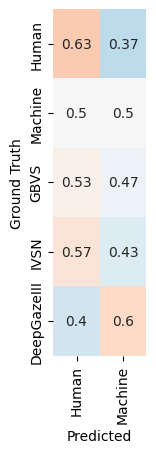

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


mean
[0.5649999976158142, 0.550000011920929, 0.5299999713897705, 0.6150000095367432]
std
[0.01032673574359088, 0.021018651103376276, 0.020047667412987843, 0.0201378336078206]


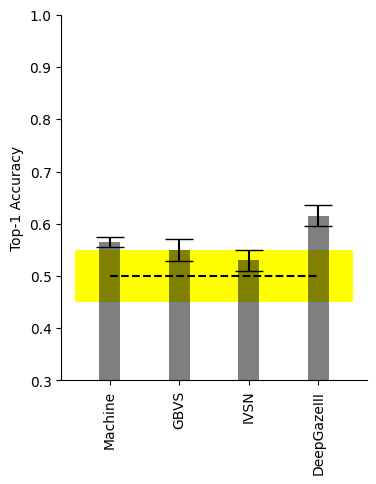

1068
['GBVS', 'IVSN', 'DeepGazeIII']
bootstraptime 534 sampletime 267
bootstraptime 178 sampletime 89
bootstraptime 178 sampletime 89
bootstraptime 178 sampletime 89


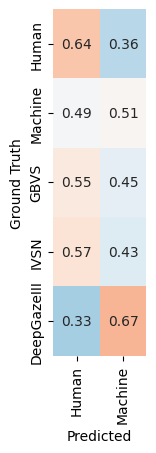

mean
[0.574999988079071, 0.5449999570846558, 0.5349999666213989, 0.6549999713897705]
std
[0.014762499484804351, 0.02872382622930549, 0.030891057534385473, 0.029293720189363406]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


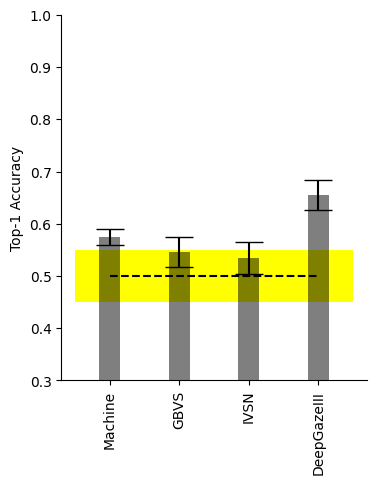

1236
['GBVS', 'IVSN', 'DeepGazeIII']
bootstraptime 618 sampletime 309
bootstraptime 206 sampletime 103
bootstraptime 206 sampletime 103
bootstraptime 206 sampletime 103


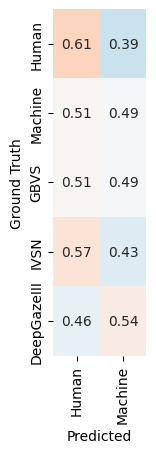

mean
[0.550000011920929, 0.550000011920929, 0.5199999809265137, 0.5750000476837158]
std
[0.01356321436625838, 0.027640138377779663, 0.028974908009960228, 0.027698018798292146]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


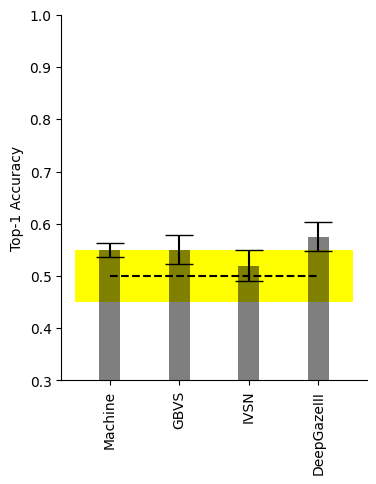

7200
['GBVS', 'IVSN', 'DeepGazeIII']
bootstraptime 3600 sampletime 1800
bootstraptime 1200 sampletime 600
bootstraptime 1200 sampletime 600
bootstraptime 1200 sampletime 600


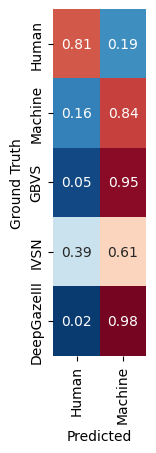

mean
[0.824999988079071, 0.8799999952316284, 0.7100000381469727, 0.8949999809265137]
std
[0.004454968720868541, 0.007831104391313801, 0.010094671846640585, 0.007655309844014828]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


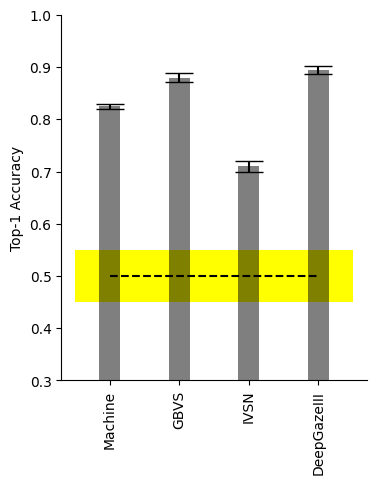

confmat for free viewing AI
[[0.81 0.19]
 [0.16 0.84]
 [0.05 0.95]
 [0.39 0.61]
 [0.02 0.98]]
5621
['GBVS', 'IVSN', 'DeepGazeIII']
bootstraptime 2807 sampletime 1404
bootstraptime 938 sampletime 469
bootstraptime 931 sampletime 466
bootstraptime 938 sampletime 469


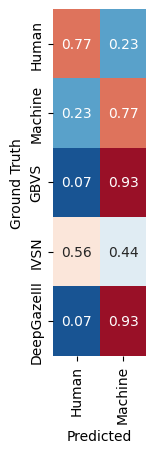

mean
[0.7699999809265137, 0.8500000238418579, 0.6050000190734863, 0.8500000238418579]
std
[0.005599203713532916, 0.010168392054938993, 0.01205071544644817, 0.010008978077439886]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


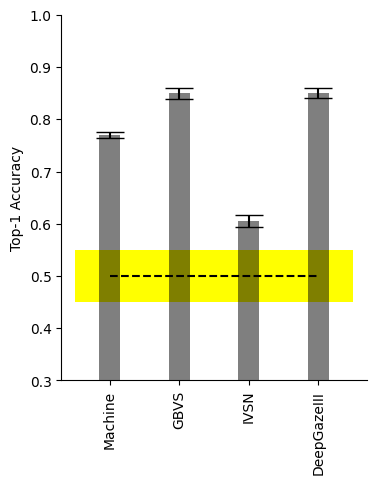

confmat for visual search AI
[[0.77 0.23]
 [0.23 0.77]
 [0.07 0.93]
 [0.56 0.44]
 [0.07 0.93]]


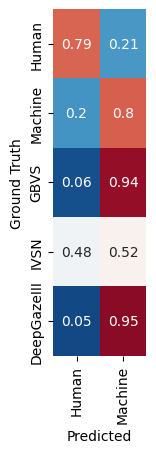

array([[0.79, 0.21],
       [0.2 , 0.8 ],
       [0.06, 0.94],
       [0.48, 0.52],
       [0.05, 0.95]], dtype=float32)

In [2]:
def plot_res_demographics_singleplot(condition_chosen, TextFilePath, condition_results, folderpath, saveflag, SkipFlag, confmat):
    
    
    if not SkipFlag:
        print(len(condition_results[condition_chosen]))
        top1, top1std, result_conf_mat, dummy = ComputeBarStdConfMat(condition_results[condition_chosen])
    else:
        result_conf_mat = confmat
    
    modelist = ['Human', 'Machine', 'GBVS', 'IVSN', 'DeepGazeIII']
    df_cm = pd.DataFrame(result_conf_mat, index = [i for i in modelist],
                  columns = [i for i in ['Human','Machine']])
    plt.figure(figsize = (1.2,4.5))
    sn.heatmap(df_cm, annot=True,robust=True, cmap='RdBu_r', vmin=0, vmax=1, cbar = False)

    plt.xlabel("Predicted")
    plt.ylabel("Ground Truth")
        
    plotname = condition_chosen
    plt.savefig(folderpath + plotname + '_overall_confmat.eps', format='eps', bbox_inches='tight')
    plt.savefig(folderpath + plotname + '_overall_confmat.png', bbox_inches='tight')
    plt.show()
    
    if saveflag == 1:
        np.save(TextFilePath + "confmat.np", result_conf_mat)
    
    if not SkipFlag:
    
        #data
        #x-axis
        years = list(range(1, len(modelist)-1))
        strtask = modelist[1:]
        #print(years)
        #print(strtask)

        # Figure Size
        fig, ax = plt.subplots()

        ax.add_patch(Rectangle((-0.5, 0.45), len(modelist)-1, 0.1,facecolor='yellow'))
        #bar chart properties
        #ax.bar(strtask, top1, color ='black', width = 0.3)
        ax.bar(strtask, top1, yerr=top1std,
           align='center', alpha=0.5, ecolor='black', capsize=10,
           color ='black', width = 0.3)

        print('mean')
        print(top1)
        print('std')
        print(top1std)

        plt.ylabel('Top-1 Accuracy')
        plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees

        plt.ylim(0.3, 1)
        #plt.xlim(0.5, len(years)+0.5)

        #draw chance 0.5 
        chancex =np.arange(len(years)+1)
        plt.plot(chancex, np.arange(len(chancex))*0+0.5, 'k--', label='chance (50%)')
        #plt.legend()

        fig.tight_layout()

        fig.set_figwidth(3.5)
        fig.set_figheight(5)

        #fig.legend(loc='upper center', bbox_to_anchor=(0.55, 1.0), ncol=3, fancybox=True, shadow=True,frameon=False)

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        plt.savefig(folderpath + plotname + '_overall_barplot.eps', format='eps', bbox_inches='tight')
        plt.savefig(folderpath + plotname + '_overall_barplot.png', bbox_inches='tight')
        plt.show()


    return result_conf_mat

#======================Plot overall results (human judges)=======
# with open("./savedResults/compiled.json", 'r') as f:
#     CompiledResults = json.load(f)

json_file_path = 'Data_all/complete_humanjudge.json'
plotname = 'complete_humanjudge'

with open(json_file_path, 'r') as j:
     contents = json.loads(j.read())
        
CompiledResults = {}
CompiledResults['mturk'] = contents


SkipFlag = 0
confmat = False #dummy confmat

key = 'mturk' #choose from these choices: inlab, mturk
TextFilePath = './savedResults/Task6_' + key + '_' #not being used
folderpath = './plots/Task6_' + key + '_' #for saving the plots
saveflag = 1 #save confmat for final plots
plot_res_demographics_singleplot(key, TextFilePath, CompiledResults, folderpath, saveflag, SkipFlag, confmat)

#======================Plot free viewing results (human judges)=======
# with open("./savedResults/compiled.json", 'r') as f:
#     CompiledResults = json.load(f)

json_file_path = 'Data_all/complete_humanjudge_FV.json'
plotname = 'complete_humanjudge_FV'

with open(json_file_path, 'r') as j:
     contents = json.loads(j.read())
        
CompiledResults = {}
CompiledResults['mturk_FV'] = contents


SkipFlag = 0
confmat = False #dummy confmat

key = 'mturk_FV' #choose from these choices: inlab, mturk
TextFilePath = './savedResults/Task6_' + key + '_' #not being used
folderpath = './plots/Task6_' + key + '_' #for saving the plots
saveflag = 1 #save confmat for final plots
plot_res_demographics_singleplot(key, TextFilePath, CompiledResults, folderpath, saveflag, SkipFlag, confmat)

#======================Plot visual search results (human judges)=======
# with open("./savedResults/compiled.json", 'r') as f:
#     CompiledResults = json.load(f)

json_file_path = 'Data_all/complete_humanjudge_VS.json'
plotname = 'complete_humanjudge_VS'

with open(json_file_path, 'r') as j:
     contents = json.loads(j.read())
        
CompiledResults = {}
CompiledResults['mturk_VS'] = contents


SkipFlag = 0
confmat = False #dummy confmat

key = 'mturk_VS' #choose from these choices: inlab, mturk
TextFilePath = './savedResults/Task6_' + key + '_' #not being used
folderpath = './plots/Task6_' + key + '_' #for saving the plots
saveflag = 1 #save confmat for final plots
plot_res_demographics_singleplot(key, TextFilePath, CompiledResults, folderpath, saveflag, SkipFlag, confmat)

# #======================Plot overall results (AI judges)=======
# with open("./savedResults/compiled.json", 'r') as f:
#     CompiledResults = json.load(f)

# SkipFlag = 1
# result_conf_mat = np.zeros((6,2),'float32')
# result_conf_mat[0][0] = 0.9
# result_conf_mat[0][1] = 0.1
# result_conf_mat[1][0] = 0.28
# result_conf_mat[1][1] = 0.72
# result_conf_mat[2][0] = 0.065
# result_conf_mat[2][1] = 0.94
# result_conf_mat[3][0] = 0.33
# result_conf_mat[3][1] = 0.67
# result_conf_mat[4][0] = 0.2
# result_conf_mat[4][1] = 0.8
# result_conf_mat[5][0] = 0.33
# result_conf_mat[5][1] = 0.67

key = 'machine' #choose from these choices: inlab, mturk
TextFilePath = './savedResults/Task6_' + key + '_' #not being used
folderpath = './plots/Task6_' + key + '_' #for saving the plots
saveflag = 1

json_file_path = 'Data_all/SVM_AIJudge_FV_balanced.json'
plotname = 'FV_AI'

with open(json_file_path, 'r') as j:
     contents_freeview = json.loads(j.read())
#print(contents_freeview)

CompiledResults = {}
CompiledResults[plotname] = contents_freeview

FV_AI_confmat = plot_res_demographics_singleplot(plotname, TextFilePath, CompiledResults, folderpath, saveflag, SkipFlag, confmat = False)
print('confmat for free viewing AI')
print(FV_AI_confmat)

json_file_path = 'Data_all/10_SVM_AIJudge_balanced.json'
plotname = 'VS_AI'

with open(json_file_path, 'r') as j:
     contents_visualsearch = json.loads(j.read())
#print(contents_visualsearch)

CompiledResults = {}
CompiledResults[plotname] = contents_visualsearch

VS_AI_confmat = plot_res_demographics_singleplot(plotname, TextFilePath, CompiledResults, folderpath, saveflag, SkipFlag, confmat = False)
print('confmat for visual search AI')
print(VS_AI_confmat)


SkipFlag = 1
confmat = (VS_AI_confmat + FV_AI_confmat)/2

result_conf_mat = np.zeros((5,2),'float32')
result_conf_mat[0][0] = 0.79
result_conf_mat[0][1] = 0.21
result_conf_mat[1][0] = 0.20
result_conf_mat[1][1] = 0.80
result_conf_mat[2][0] = 0.06
result_conf_mat[2][1] = 0.94
result_conf_mat[3][0] = 0.48
result_conf_mat[3][1] = 0.52
result_conf_mat[4][0] = 0.05
result_conf_mat[4][1] = 0.95

#print(confmat)
plot_res_demographics_singleplot(key, TextFilePath, CompiledResults, folderpath, saveflag, SkipFlag, result_conf_mat)
